####	Имеется отрезок длины L. Написать алгоритм разбиения отрезка на более мелкие, при этом длина разбивающего отрезка должна увеличиваться от одного конца к другому. Считать, что стартовый разбивающий отрезок задан и имеет длину l, а каждый последующий увеличивается в q раз (q>1). При каких значениях l, q возможно точное разбиение для заданного L?  Если точное разбиение невозможно, написать алгоритм минимальной коррекции вводимых параметров l и q и обеспечить точное разбиение.

In [8]:
import numpy as np
from math import log, ceil

def find_number_of_terms(L, l, q):
    return ceil(log(1 + L * (q - 1) / l, q))

def small_segment_correction(L, l, q):
    n = find_number_of_terms(L, l, q)
    return L * (q - 1) / (q**n - 1)

def split_segment(L, l, q):
    n = find_number_of_terms(L, l, q)
    segments, current_length = [], small_segment_correction(L, l, q)
    
    for _ in range(n):
        segments.append(current_length)
        current_length *= q
    return segments

print(sum(split_segment(16, 1, 2)))

16.0


#### Имеется набор N векторов из двумерного пространства. Известно, что x, y координаты M векторов равномерно распределены на [0,1], а концы других N-M векторов образуют в пространстве R2 кривую вида x^2/a^2  + y^2/b^2  + n = 1, где n - нормальный шум с нулевым средним и дисперсией ≪a,b. Метки классов выставлены случайно неверно в 5% случаев для каждого класса. Необходимо разработать линейно-регрессионную модель, определяющая, к какому из двух классов принадлежит каждая точка из представленного множества. Алгоритм не должен опираться на априорные знания о виде описанной выше кривой.

In [12]:
import torch
import numpy as np

N = 1000  # Количество векторов
M = 800   # Количество векторов с равномерным распределением

uniform_vectors = torch.rand(M, 2)

# Генерация векторов с кривой
a = 0.5
b = 0.8
noise = torch.normal(0, 0.01, size=(N-M, 1))
x = torch.linspace(-a, a, N-M).reshape(-1, 1)
y = torch.sqrt((1 - x**2 / a**2) * b**2) + noise
curve_vectors = torch.cat((x, y), dim=1)

vectors = torch.cat((uniform_vectors, curve_vectors), dim=0)

labels = torch.zeros(N)
labels[:M] = 1

incorrect_indices = np.random.choice(N, int(N*0.05), replace=False)
labels[incorrect_indices] = 1 - labels[incorrect_indices]


print(vectors.shape)
print(labels.shape)

torch.Size([1000, 2])
torch.Size([1000])


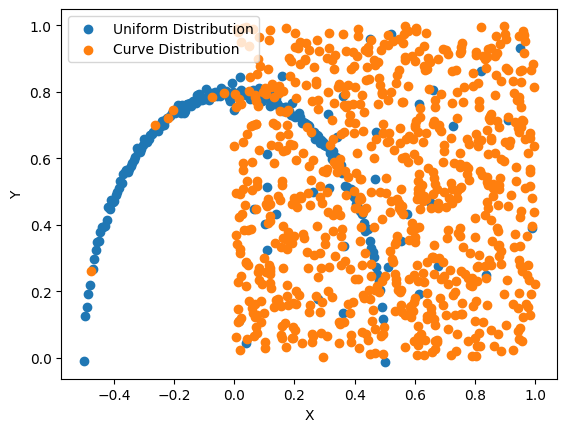

In [59]:
import matplotlib.pyplot as plt

# Построение графика
plt.scatter(uniform_vectors[:, 0], uniform_vectors[:, 1], label='Uniform Distribution')
plt.scatter(curve_vectors[:, 0], curve_vectors[:, 1], label='Curve Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [56]:
from sklearn.model_selection import train_test_split

# Разделение данных на тренировочные и тестовые наборы
train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors, labels, test_size=0.3, random_state=42)

train_vectors, test_vectors, train_labels, test_labels = np.array(train_vectors), np.array(test_vectors), np.array(train_labels), np.array(test_labels)
print(type(train_vectors))

<class 'numpy.ndarray'>


In [58]:
# Создание модели логистической регрессии
class LogisticRegression:
    def __init__(self, input_size):
        self.input_size = input_size
        self.weights = np.zeros(input_size)
        self.bias = 0
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x):
        linear = np.dot(x, self.weights) + self.bias
        out = self.sigmoid(linear)
        return out
    
    def backward(self, x, y, lr):
        predicted = self.forward(x)
        error = predicted - y
        dw = np.dot(x.T, error)
        db = np.sum(error)
        
        self.weights -= lr * dw
        self.bias -= lr * db

# Создание модели
input_size = train_vectors.shape[1]
model = LogisticRegression(input_size)

# Обучение модели
num_epochs = 1000
learning_rate = 0.01
for epoch in range(num_epochs):
    # Прямой проход
    outputs = model.forward(train_vectors)
    
    # Обратное распространение и оптимизация
    model.backward(train_vectors, train_labels, learning_rate)

# Тестирование модели
predicted = model.forward(test_vectors)
predicted_labels = np.round(predicted)
accuracy = (predicted_labels == test_labels.astype(int)).sum().item() / len(test_labels)
print("Accuracy:", accuracy)

Accuracy: 0.8233333333333334


#### Написать алгоритм генерации бинарного изображения, содержащее непересекающиеся произвольные (разной геометрии и размеров) треугольники и прямоугольники. Необходимо распознать и повернуть все треугольники на изображении на 45 градусов относительно своих центров масс. Учесть наличие пересечения поворачиваемых фигур: если поворот невозможен без пересечения, выдавать предупреждение. Запрещено пользоваться готовыми функциями из пакетов image processing.

In [1]:
from PIL import Image, ImageDraw
import random

def check_triangle_intersection(shapes, x1, y1, x2, y2, x3, y3): 
    for shape in shapes: 
        if (x1 < shape[2] and x2 > shape[0] and y1 < shape[3] and y2 > shape[1]) or \
           (x3 < shape[2] and x3 > shape[0] and y3 < shape[3] and y3 > shape[1]) or \
           (x2 < shape[2] and x3 > shape[0] and y2 < shape[3] and y3 > shape[1]): 
            return True
    return False

def check_rectangle_intersection(shapes, x, y, width, height):
    for shape in shapes:
        if x < shape[2] and x + width > shape[0] and y < shape[3] and y + height > shape[1]:
            return True
    return False

def generate_image(num_shapes, min_shape_size, max_shape_size):
    image_width = 500
    image_height = 500
    image = Image.new("1", (image_width, image_height))

    draw = ImageDraw.Draw(image)

    shapes = []  # Список для хранения координат и размеров фигур

    for _ in range(num_shapes):
        shape_type = random.choice(["triangle", "rectangle"])
        
        if shape_type == "triangle":
            while True:
                # Генерируем случайные координаты вершин треугольника
                x1 = random.randint(0, image_width)
                y1 = random.randint(0, image_height)
                x2 = random.randint(x1, min(x1 + max_shape_size, image_width))
                y2 = random.randint(y1, min(y1 + max_shape_size, image_height))
                x3 = random.randint(x1, min(x1 + max_shape_size, image_width))
                y3 = random.randint(y1, min(y1 + max_shape_size, image_height))
                
                if not check_triangle_intersection(shapes, x1, y1, x2, y2, x3, y3):
                    break

            draw.polygon([(x1, y1), (x2, y2), (x3, y3)], fill=1)
            
            shapes.append((x1, y1, x2, y2, x3, y3))
        
        elif shape_type == "rectangle":
            while True:
                # Генерируем случайные координаты верхнего левого угла и размеры прямоугольника
                x = random.randint(0, image_width)
                y = random.randint(0, image_height)
                width = random.randint(min_shape_size, min(min_shape_size + max_shape_size, image_width - x))
                height = random.randint(min_shape_size, min(min_shape_size + max_shape_size, image_height - y))
                
                if not check_rectangle_intersection(shapes, x, y, width, height):
                    break
            

            draw.rectangle([(x, y), (x + width, y + height)], fill=1)
            shapes.append((x, y, x + width, y + height))

    return image

num_shapes, min_size, max_size = 5, 25, 125

image = generate_image(num_shapes, min_size, max_size)
image.save('shapes.jpg')

#### Пояснение к условиям перечесения: 
check_triangle_intersection:

1. Если хотя бы одна из вершин треугольника находится внутри другой фигуры, то есть если x1 находится между shape[0] и shape[2], и y1 находится между shape[1] и shape[3].

2. Аналогично для второй вершины треугольника (x2, y2).

3. И наконец, для третьей вершины треугольника (x3, y3).

check_rectangle_intersection

1. x < shape[2]: проверяет, что левая сторона прямоугольника не выходит за правую сторону другой фигуры.

2. x + width > shape[0]: проверяет, что правая сторона прямоугольника не выходит за левую сторону другой фигуры.

3. y < shape[3]: проверяет, что верхняя сторона прямоугольника не выходит за нижнюю сторону другой фигуры.

4. y + height > shape[1]: проверяет, что нижняя сторона прямоугольника не выходит за верхнюю сторону другой фигуры.


In [2]:
import cv2
import numpy as np

image = cv2.imread('shapes.jpg', 0)

contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    # Приближение контура до многоугольника с малым числом вершин
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # Если многоугольник имеет 4 вершины, это прямоугольник
    if len(approx) == 4:
        cv2.drawContours(image, [approx], 0, (50), 2)
        
    # Если многоугольник имеет 3 вершины, это треугольник
    elif len(approx) == 3:
        cv2.drawContours(image, [approx], 0, (250), 2)
        
cv2.imshow('Output Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
import cv2
import numpy as np

def detect_trinangles(binary_image, acc=0.03):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    triangles = []

    for contour in contours:
        epsilon = acc * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Если приближенный контур содержит 3 вершины, то это треугольник
        if len(approx) == 3:
            x1, y1 = approx[0][0]
            x2, y2 = approx[1][0]
            x3, y3 = approx[2][0]

            triangles.append([(x1, y1), (x2, y2), (x3, y3)])

    return triangles

def detect_rectangles(binary_image, acc=0.03):
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rectangles = []

    for contour in contours:
        epsilon = acc * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:
            x1, y1 = approx[0][0]
            x3, y3 = approx[2][0]

            rectangles.append([(x1, y1), (x3, y3)])
    
    return rectangles


image = cv2.imread('shapes.jpg', 0)

triangles, rectangles = detect_trinangles(image), detect_rectangles(image)

print('Triangles:', *triangles, sep='\n')
print()
print('Rectangles:', *rectangles, sep='\n')

Triangles:
[(296, 320), (329, 391), (383, 349)]

Rectangles:
[(352, 464), (423, 499)]
[(454, 216), (481, 343)]
[(457, 96), (471, 191)]


In [4]:
def get_centers_of_mass(triangles):
    centers = []
    for triangle in triangles:
        x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
        y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
        centers.append((x, y))
    return centers

centers = get_centers_of_mass(triangles)
print(*centers)

(336.0, 353.3333333333333)


In [5]:
from math import sin, cos, radians

def rotate_point(point, center, angle):
    translated_point = (point[0] - center[0], point[1] - center[1])
    
    rotated_x = translated_point[0] * cos(radians(angle)) - translated_point[1] * sin(radians(angle))
    rotated_y = translated_point[0] * sin(radians(angle)) + translated_point[1] * cos(radians(angle))

    rotated_point = (rotated_x + center[0], rotated_y + center[1])

    return rotated_point

point = (50, 0)
rotated_point = rotate_point(point, (0, 0), 90)
print(rotated_point)

(3.061616997868383e-15, 50.0)


In [6]:
def rotate_triangle(triangle, center, angle):
    rotated_triangle = []
    for point in triangle:
        rotated_triangle.append(rotate_point(point, center, angle))
    
    return rotated_triangle

rotated_triangles = [rotate_triangle(triangle, center, 45) for triangle, center in zip(triangles, centers)]
print('Rotated triangles:', *rotated_triangles, sep='\n')

Rotated triangles:
[(331.2859547920897, 301.4788360463198), (304.4158971070009, 375.0179412897208), (372.29814810090943, 383.5032226639594)]


In [18]:
from PIL import Image, ImageDraw

def generate_rotated_image(triangles, rectangles): 
    image_width = 500 
    image_height = 500 
    rotated_image = Image.new("1", (image_width, image_height)) 
 
    draw = ImageDraw.Draw(rotated_image) 
 
    for triangle in triangles: 
        draw.polygon(triangle, fill=1) 
    for rectangle in rectangles:
        draw.rectangle(rectangle, fill=1) 
 
    return rotated_image

rotated_image = generate_rotated_image(rotated_triangles, rectangles) 
rotated_image.save('rotated_shapes.jpg')
